In [1]:
!pip install flatten_json
import joblib

import pandas as pd
import json as json
from flatten_json import flatten

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
import pickle


In [2]:
def process_city(city, cars_df):
  city_df = pd.read_excel(f'./capstone-3-datasets/{city}_cars.xlsx')

  for index,row in city_df.iterrows():
    car_dict = flatten(json.loads(row.new_car_detail.replace("'",'"').replace('None','null')))
    car_dict['city']=city

    for element in json.loads(row.new_car_overview.replace("'",'"').replace('None','null'))['top']:
      car_dict['o_' + element['key']] = element['value']

    for item in json.loads(row.new_car_feature.replace("'",'"').replace('None','null'))['top']:
      car_dict['f_' + item['value']] = 1

    for item in json.loads(row.new_car_specs.replace("'",'"').replace('None','null'))['top']:
      car_dict['s_' + item['key']] = item['value']

    cars_df = pd.concat([cars_df, pd.DataFrame([car_dict])])

  return cars_df


In [3]:
cities = ['chennai','bangalore','delhi','hyderabad','jaipur','kolkata']
cars_df = pd.DataFrame()
for city in cities:
  cars_df = process_city(city, cars_df)

In [4]:
cars_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 8369 entries, 0 to 0
Data columns (total 111 columns):
 #    Column                                           Non-Null Count  Dtype  
---   ------                                           --------------  -----  
 0    it                                               8369 non-null   int64  
 1    ft                                               8369 non-null   object 
 2    bt                                               8369 non-null   object 
 3    km                                               8369 non-null   object 
 4    transmission                                     8369 non-null   object 
 5    ownerNo                                          8369 non-null   int64  
 6    owner                                            8369 non-null   object 
 7    oem                                              8369 non-null   object 
 8    model                                            8369 non-null   object 
 9    modelYear                

In [5]:
cars_df = cars_df[['ft','o_Kms Driven','transmission','s_Mileage','ownerNo','modelYear','price','city','oem','model']]
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8369 entries, 0 to 0
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ft            8369 non-null   object
 1   o_Kms Driven  8367 non-null   object
 2   transmission  8369 non-null   object
 3   s_Mileage     8082 non-null   object
 4   ownerNo       8369 non-null   int64 
 5   modelYear     8369 non-null   int64 
 6   price         8369 non-null   object
 7   city          8369 non-null   object
 8   oem           8369 non-null   object
 9   model         8369 non-null   object
dtypes: int64(2), object(8)
memory usage: 719.2+ KB


In [6]:
# Check for duplicates
cars_df.duplicated().sum()

127

In [7]:
# Remove duplicates
cars_df = cars_df.drop_duplicates()
cars_df.duplicated().sum()

0

In [8]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8242 entries, 0 to 0
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ft            8242 non-null   object
 1   o_Kms Driven  8240 non-null   object
 2   transmission  8242 non-null   object
 3   s_Mileage     7961 non-null   object
 4   ownerNo       8242 non-null   int64 
 5   modelYear     8242 non-null   int64 
 6   price         8242 non-null   object
 7   city          8242 non-null   object
 8   oem           8242 non-null   object
 9   model         8242 non-null   object
dtypes: int64(2), object(8)
memory usage: 708.3+ KB


In [9]:
cars_df.head(10)

,ft,o_Kms Driven,transmission,s_Mileage,ownerNo,modelYear,price,city,oem,model
0,Petrol,"20,000 Kms",Automatic,NaN,1,2022,₹ 11.50 Lakh,chennai,Kia,Kia Sonet
0,Petrol,"20,687 Kms",Manual,15.37 kmpl,1,2015,₹ 4.15 Lakh,chennai,Maruti,Maruti Eeco
0,Petrol,"30,000 Kms",Manual,20 kmpl,1,2021,₹ 7.50 Lakh,chennai,Nissan,Nissan Magnite
0,Petrol,"59,247 Kms",Manual,19.81 kmpl,1,2015,₹ 3.98 Lakh,chennai,Hyundai,Hyundai i10
0,Petrol,"50,000 Kms",Manual,18.7 kmpl,1,2015,₹ 5.50 Lakh,chennai,Honda,Honda Jazz
0,Diesel,"20,000 Kms",Automatic,13 kmpl,1,2016,₹ 33 Lakh,chennai,Mercedes-Benz,Mercedes-Benz E-Class
0,Petrol,"29,403 Kms",Automatic,23.1 kmpl,1,2016,₹ 4.53 Lakh,chennai,Maruti,Maruti Celerio
0,Petrol,"42,700 Kms",Manual,19 kmpl,1,2010,₹ 2.85 Lakh,chennai,Maruti,Maruti A-Star
0,Diesel,"23,001 Kms",Automatic,16.55 kmpl,1,2018,₹ 50 Lakh,chennai,BMW,BMW X3
0,Petrol,"25,925 Kms",Automatic,14.8 kmpl,2,2018,₹ 8.21 Lakh,chennai,Ford,Ford Ecosport


In [10]:
cars_df['mileage'] = cars_df['s_Mileage'].str.replace(' kmpl','')
cars_df['mileage'] = cars_df['mileage'].str.replace(' km/kg','')
cars_df['mileage'] = pd.to_numeric(cars_df['mileage'])
cars_df['mileage'].info()

<class 'pandas.core.series.Series'>
Index: 8242 entries, 0 to 0
Series name: mileage
Non-Null Count  Dtype  
--------------  -----  
7961 non-null   float64
dtypes: float64(1)
memory usage: 128.8 KB


<ipython-input-10-fd0afa07fdac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars_df['mileage'] = cars_df['s_Mileage'].str.replace(' kmpl','')
<ipython-input-10-fd0afa07fdac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars_df['mileage'] = cars_df['mileage'].str.replace(' km/kg','')
<ipython-input-10-fd0afa07fdac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [11]:
cars_df['mileage'].fillna(cars_df['mileage'].median(), inplace=True)
cars_df.drop('s_Mileage', axis=1, inplace=True)
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8242 entries, 0 to 0
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ft            8242 non-null   object 
 1   o_Kms Driven  8240 non-null   object 
 2   transmission  8242 non-null   object 
 3   ownerNo       8242 non-null   int64  
 4   modelYear     8242 non-null   int64  
 5   price         8242 non-null   object 
 6   city          8242 non-null   object 
 7   oem           8242 non-null   object 
 8   model         8242 non-null   object 
 9   mileage       8242 non-null   float64
dtypes: float64(1), int64(2), object(7)
memory usage: 708.3+ KB


<ipython-input-11-0be0222b6a4b>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cars_df['mileage'].fillna(cars_df['mileage'].median(), inplace=True)
<ipython-input-11-0be0222b6a4b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars_df['mileage'].fillna(cars_df['mileage'].median(), inplace=True)
<ipython-input-11-0be0222b6a4b>:2: SettingWit

In [12]:
cars_df['o_Kms'] = cars_df['o_Kms Driven'].str.replace(' Kms', '')
cars_df['o_Kms'] = cars_df['o_Kms'].str.replace(',', '')
cars_df['o_Kms'] = pd.to_numeric(cars_df['o_Kms'])
cars_df.drop('o_Kms Driven', axis=1, inplace=True)
cars_df['o_Kms'].info()

<class 'pandas.core.series.Series'>
Index: 8242 entries, 0 to 0
Series name: o_Kms
Non-Null Count  Dtype  
--------------  -----  
8240 non-null   float64
dtypes: float64(1)
memory usage: 128.8 KB


In [13]:
cars_df['o_Kms'].fillna(cars_df['o_Kms'].median(), inplace=True)

cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8242 entries, 0 to 0
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ft            8242 non-null   object 
 1   transmission  8242 non-null   object 
 2   ownerNo       8242 non-null   int64  
 3   modelYear     8242 non-null   int64  
 4   price         8242 non-null   object 
 5   city          8242 non-null   object 
 6   oem           8242 non-null   object 
 7   model         8242 non-null   object 
 8   mileage       8242 non-null   float64
 9   o_Kms         8242 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 708.3+ KB


<ipython-input-13-da1efa95b545>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cars_df['o_Kms'].fillna(cars_df['o_Kms'].median(), inplace=True)


<Axes: ylabel='o_Kms'>

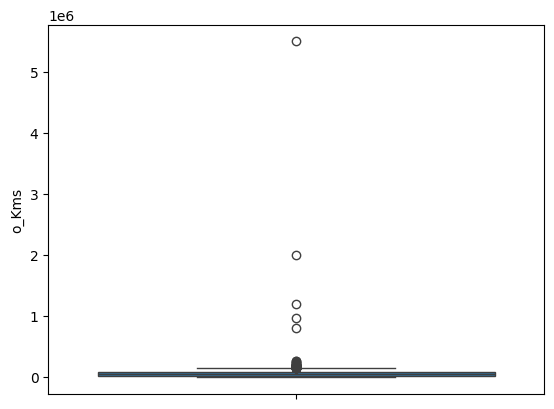

In [14]:
sns.boxplot(cars_df['o_Kms'])

<Axes: ylabel='mileage'>

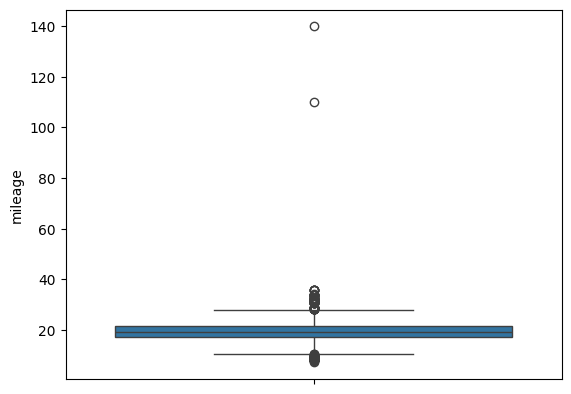

In [15]:
sns.boxplot(cars_df['mileage'])

In [16]:
def remove_outlier(df, columnName):
  Q1 = df[columnName].quantile(0.25)
  Q3 = df[columnName].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df = df[(df[columnName] >= lower_bound) & (df[columnName] <= upper_bound)]
  return df

In [17]:
cars_df = remove_outlier(cars_df, 'o_Kms')
cars_df = remove_outlier(cars_df, 'mileage')
len(cars_df)

8042

<Axes: ylabel='o_Kms'>

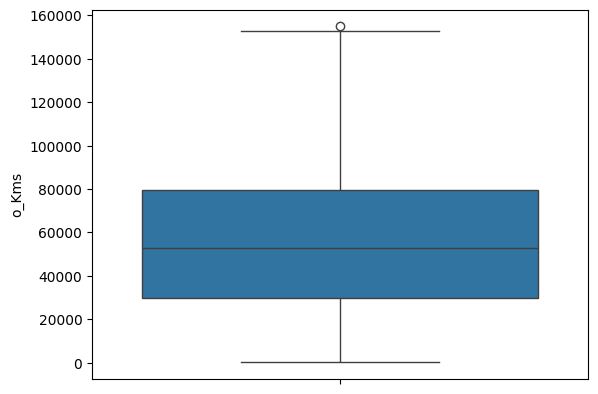

In [18]:
sns.boxplot(cars_df['o_Kms'])


<Axes: ylabel='mileage'>

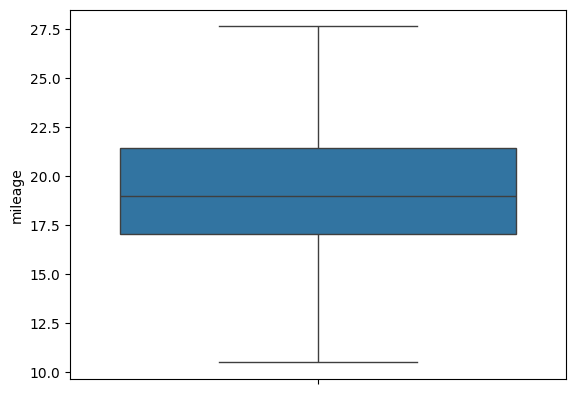

In [19]:
sns.boxplot(cars_df['mileage'])

In [20]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8042 entries, 0 to 0
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ft            8042 non-null   object 
 1   transmission  8042 non-null   object 
 2   ownerNo       8042 non-null   int64  
 3   modelYear     8042 non-null   int64  
 4   price         8042 non-null   object 
 5   city          8042 non-null   object 
 6   oem           8042 non-null   object 
 7   model         8042 non-null   object 
 8   mileage       8042 non-null   float64
 9   o_Kms         8042 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 691.1+ KB


In [21]:
def convert_number(input):
  if(input.endswith(' Lakh')):
    return float(input[:-5])*100000
  elif(input.endswith(' Crore')):
    return float(input[:-6])*10000000
  else:
    return float(input)

In [22]:
cars_df['t_price'] = cars_df['price'].str.replace('₹ ','')
cars_df['t_price'] = cars_df['t_price'].str.replace(',','')
cars_df['t_price'] = cars_df['t_price'].apply(convert_number)
cars_df.drop('price', axis=1, inplace=True)
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8042 entries, 0 to 0
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ft            8042 non-null   object 
 1   transmission  8042 non-null   object 
 2   ownerNo       8042 non-null   int64  
 3   modelYear     8042 non-null   int64  
 4   city          8042 non-null   object 
 5   oem           8042 non-null   object 
 6   model         8042 non-null   object 
 7   mileage       8042 non-null   float64
 8   o_Kms         8042 non-null   float64
 9   t_price       8042 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 691.1+ KB


In [24]:
cars_df_encoded = pd.get_dummies(cars_df, columns=['transmission','city','ft','oem','model'], drop_first=True)

In [25]:
corr_df = cars_df_encoded.corr().unstack().reset_index()
corr_df[corr_df['level_0'] == 't_price']

,level_0,level_1,0
1424,t_price,ownerNo,-0.123363
1425,t_price,modelYear,0.306141
1426,t_price,mileage,-0.282525
1427,t_price,o_Kms,-0.215394
1428,t_price,t_price,1.000000
...,...,...,...
1775,t_price,model_Volvo S90,0.031517
1776,t_price,model_Volvo V40,0.009861
1777,t_price,model_Volvo XC 90,0.068775
1778,t_price,model_Volvo XC40,0.080150


In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_values', OneHotEncoder(handle_unknown='ignore'), ['ft','transmission','city','oem','model']),  # One-hot encode the categorical feature
        ('numerical_values', StandardScaler(), ['ownerNo', 'modelYear','mileage','o_Kms']),  # Standard scale the numerical features
    ]
)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('model', LinearRegression())  # Fit the linear regression model
])

In [27]:
def fit_transform(X, y, model_pipeline, name):
  test_size, random_value = (20, 17)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size/100, random_state=random_value)

  model_pipeline.fit(X_train, y_train)

  mse_train = mean_squared_error(y_train, model_pipeline.predict(X_train))
  mse_test = mean_squared_error(y_test, model_pipeline.predict(X_test))

  print(name, test_size/100, random_value, r2_score(y_train, model_pipeline.predict(X_train)), r2_score(y_test, model_pipeline.predict(X_test)))

  joblib.dump(model_pipeline, f'./{name}_model.pkl')

  return model_pipeline



In [28]:
new_data = {
    'ownerNo': 1,
    'modelYear': 2018,
    'mileage': 16.55,
    'o_Kms': 22000.0,
    'transmission': 'Automatic',
    'city': 'chennai',
    'ft': 'Diesel',
    'oem': 'BMW',
    'model': 'BMW X3'
}

X = cars_df.drop(['t_price'], axis=1)
y = cars_df['t_price']

trained_lr_model = fit_transform(X, y, model_pipeline, 'lr')
print(trained_lr_model.predict(pd.DataFrame().from_dict([new_data])))


lr 0.2 17 0.9054032286300694 0.91532017793127
[3845609.54404991]
